In [2]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [42]:
data = pd.read_csv('DF_for_fitting.csv')

In [43]:
data.head()

,plot_id,subplot_id,measyear,tree_cn,tree_id,dbh,dg_in_x,diamincr_mm,MAT,MAP,slope,aspect,elev,dg_in_y,bal,cr,ba
0,5931423010901,5931430010901,2004,5931443010901,101,44.5,1.2,30.48,5.550000,2486.500000,95.0,265.0,3700,0.60,0.0,0.45,61.933283
1,5931423010901,5931432010901,2004,5931489010901,124,29.2,1.1,27.94,5.550000,2486.500000,95.0,320.0,3700,0.55,22.0,0.40,114.766495
2,5936567010901,5936575010901,2004,5936598010901,102,21.0,1.3,33.02,5.972727,716.454545,45.0,159.0,5900,0.65,0.0,0.90,25.491535
3,5936567010901,5936577010901,2004,5936610010901,112,20.0,2.4,60.96,5.972727,716.454545,49.0,288.0,5900,1.20,15.0,0.80,33.913766
4,5936567010901,5936578010901,2004,5936618010901,116,24.5,0.6,15.24,5.972727,716.454545,45.0,140.0,5900,0.30,0.0,0.90,5.758093


In [44]:
data['ASPECT'] = data.aspect * np.pi/180 # convert to radians
data['SLOPE'] = data.slope/100. # convert to percent

In [45]:
# for random forests, don't make any data transformations
DBH = data.dbh
BAL = data.bal
SLOPE = data.SLOPE
ASPECT = data.ASPECT
ELEV = data.elev
CR = data.cr
BA = data.ba
MAT = data.MAT
MAP = data.MAP
DDS = ((data.dg_in_x)**2)

In [11]:
# run a Random Forests regression model, allow 12 splits in each tree
regr = RandomForestRegressor(n_estimators=1000, max_depth=12, oob_score=True)
X_cols = ['dbh', 'bal', 'SLOPE', 'ASPECT', 'elev', 'cr', 'ba', 'MAT', 'MAP']
regr.fit(X=data[X_cols], y=(data.dg_in_x)**2)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [12]:
regr.oob_score_ # Random Forests R2 value on out-of-bag data

0.49469881430161733

In [46]:
# Make some data transformations to fit GLM
LOGDBH = np.log(DBH).rename('LOGDBH')
DBHSQ = (DBH**2).rename('DBHSQ')
BALDBH = (BAL/np.log(DBH+1)).rename('BALDBH')
SLOPECOSASP = (SLOPE * np.cos(ASPECT)).rename('SLOPECOSASP')
SLOPESINASP = (SLOPE * np.sin(ASPECT)).rename('SLOPESINASP')
SLOPESQ = (SLOPE**2).rename('SLOPESQ')
LOGMAT10 = (np.log(MAT+10)).rename('LOGMAT10')
LOGMAP = (np.log(MAP)).rename('LOGMAP')
DBHDIFF = data.dg_in_x.rename('DBHDIFF')
cols = [DDS.rename('DDS'),DBHDIFF,LOGDBH,DBHSQ,BALDBH,SLOPECOSASP,SLOPESINASP,SLOPE,SLOPESQ,ELEV,CR,BA,LOGMAT10,LOGMAP]
data = pd.concat(cols, axis=1)

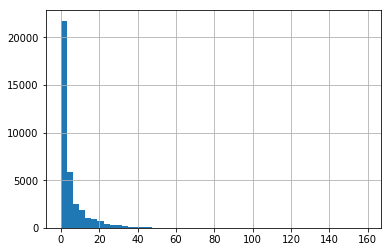

In [23]:
DDS.hist(bins=50)

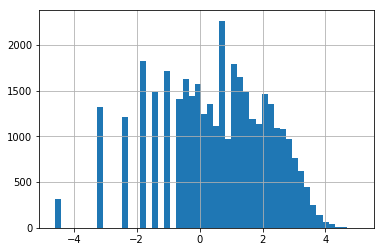

In [24]:
np.log(DDS).hist(bins=50)

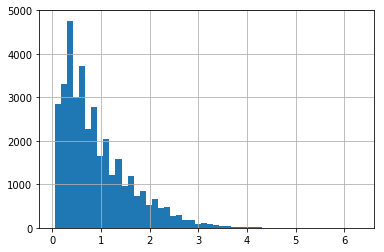

In [25]:
(np.sqrt(DDS)/2).hist(bins=50)

In [26]:
data.head()

,DDS,LOGDBH,DBHSQ,BALDBH,SLOPECOSASP,SLOPESINASP,SLOPE,SLOPESQ,elev,cr,ba,LOGMAT10,LOGMAP
0,1.44,3.795489,1980.25,0.000000,-0.082798,-0.946385,0.95,0.9025,3700,0.45,61.933283,2.744061,7.818631
1,1.21,3.374169,852.64,6.455699,0.727742,-0.610648,0.95,0.9025,3700,0.40,114.766495,2.744061,7.818631
2,1.69,3.044522,441.00,0.000000,-0.420111,0.161266,0.45,0.2025,5900,0.90,25.491535,2.770883,6.574315
3,5.76,2.995732,400.00,4.926881,0.151418,-0.466018,0.49,0.2401,5900,0.80,33.913766,2.770883,6.574315
4,0.36,3.198673,600.25,0.000000,-0.344720,0.289254,0.45,0.2025,5900,0.90,5.758093,2.770883,6.574315


In [27]:
formula = 'DDS ~ LOGDBH + DBHSQ + BALDBH + SLOPECOSASP + SLOPESINASP + SLOPE + SLOPESQ + elev + cr + ba + LOGMAT10 + LOGMAP'
base_model = smf.glm(formula=formula, data=data, family=sm.families.Gaussian(sm.families.links.log)).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    DDS   No. Observations:                36415
Model:                            GLM   Df Residuals:                    36402
Model Family:                Gaussian   Df Model:                           12
Link Function:                    log   Scale:                    37.712482838
Method:                          IRLS   Log-Likelihood:            -1.1776e+05
Date:                Tue, 12 Dec 2017   Deviance:                   1.3728e+06
Time:                        00:05:04   Pearson chi2:                 1.37e+06
No. Iterations:                    16                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -4.1931      0.200    -20.931      0.000      -4.586      -3.800
LOGDBH          0.4655      0.022     21.537      0.000       0.423       0.508
DBHSQ          -0.0013    3.9e-05    -33.874      0.000      -0.001      -0.001
BALDBH         -0.0473      0.001    -36.910      0.000      -0.050      -0.045
SLOPECOSASP    -0.0207      0.016     -1.296      0.195      -0.052       0.011
SLOPESINASP    -0.0914      0.016     -5.775      0.000      -0.122      -0.060
SLOPE           0.4155      0.062      6.714      0.000       0.294       0.537
SLOPESQ        -1.0615      0.076    -13.917      0.000      -1.211      -0.912
elev           -0.0002   4.49e-06    -51.461      0.000      -0.000      -0.000
cr              2.0413      0.028     72.221      0.000       1.986       2.097
ba             -0.0013      0.000     -3.787      0.000      -0.002      -0.001
LOGMAT10        0.5542      0.055      9.990      0.000       0.446       0.663
LOGMAP          0.4593      0.010     44.871      0.000       0.439       0.479
===============================================================================
"""

In [29]:
formula = 'DDS ~ LOGDBH + DBHSQ + BALDBH + SLOPECOSASP + SLOPESINASP + SLOPE + SLOPESQ + elev + cr + ba + LOGMAT10 + LOGMAP'
gamma_model = smf.glm(formula=formula, data=data, family=sm.families.Gamma(sm.families.links.log)).fit()
gamma_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    DDS   No. Observations:                36415
Model:                            GLM   Df Residuals:                    36402
Model Family:                   Gamma   Df Model:                           12
Link Function:                    log   Scale:                   3.98019714167
Method:                          IRLS   Log-Likelihood:                -93222.
Date:                Tue, 12 Dec 2017   Deviance:                       46949.
Time:                        00:05:33   Pearson chi2:                 1.45e+05
No. Iterations:                   100                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -7.2253      0.352    -20.554      0.000      -7.914      -6.536
LOGDBH         -0.0390      0.034     -1.145      0.252      -0.106       0.028
DBHSQ          -0.0005   2.82e-05    -16.297      0.000      -0.001      -0.000
BALDBH         -0.0519      0.002    -29.068      0.000      -0.055      -0.048
SLOPECOSASP    -0.0594      0.033     -1.792      0.073      -0.124       0.006
SLOPESINASP    -0.0278      0.032     -0.865      0.387      -0.091       0.035
SLOPE          -0.5613      0.139     -4.041      0.000      -0.834      -0.289
SLOPESQ        -0.2773      0.151     -1.840      0.066      -0.573       0.018
elev           -0.0002   9.94e-06    -21.799      0.000      -0.000      -0.000
cr              2.5827      0.058     44.175      0.000       2.468       2.697
ba              0.0006      0.001      0.961      0.336      -0.001       0.002
LOGMAT10        1.5352      0.106     14.457      0.000       1.327       1.743
LOGMAP          0.5868      0.021     27.429      0.000       0.545       0.629
===============================================================================
"""

In [65]:
formula = 'DDS ~ LOGDBH + DBHSQ + BALDBH + SLOPECOSASP + SLOPESINASP + SLOPE + SLOPESQ + elev + cr + ba + LOGMAT10 + LOGMAP'
gamma2_model = smf.glm(formula=formula, data=data, family=sm.families.Gamma()).fit()
gamma2_model.summary()

//anaconda/envs/pymc/lib/python3.5/site-packages/statsmodels/genmod/generalized_linear_model.py:244: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  DomainWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    DDS   No. Observations:                36415
Model:                            GLM   Df Residuals:                    36402
Model Family:                   Gamma   Df Model:                           12
Link Function:          inverse_power   Scale:                   2.13555032951
Method:                          IRLS   Log-Likelihood:                -99286.
Date:                Tue, 12 Dec 2017   Deviance:                   1.1429e+05
Time:                        01:04:25   Pearson chi2:                 7.77e+04
No. Iterations:                    10                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.2434      0.019    120.588      0.000       2.207       2.280
LOGDBH         -0.0459      0.001    -55.618      0.000      -0.048      -0.044
DBHSQ           0.0002   2.56e-06     59.745      0.000       0.000       0.000
BALDBH          0.0130      0.000    116.147      0.000       0.013       0.013
SLOPECOSASP     0.0078      0.000     21.873      0.000       0.007       0.008
SLOPESINASP     0.0247      0.000     67.691      0.000       0.024       0.025
SLOPE          -0.0230      0.002    -11.111      0.000      -0.027      -0.019
SLOPESQ         0.1530      0.003     53.065      0.000       0.147       0.159
elev         3.938e-05   3.26e-07    120.739      0.000    3.87e-05       4e-05
cr             -0.3815      0.003   -124.515      0.000      -0.388      -0.375
ba              0.0003   1.27e-05     23.445      0.000       0.000       0.000
LOGMAT10       -0.3599      0.003   -107.702      0.000      -0.366      -0.353
LOGMAP         -0.1154      0.001   -120.368      0.000      -0.117      -0.114
===============================================================================
"""

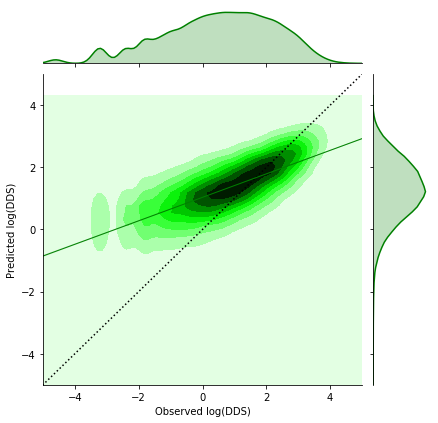

In [74]:
observed = np.log(DDS)
predicted = np.log(base_model.mu)
g = sns.jointplot(observed, predicted, kind='kde', color='g', xlim=(-5,5), ylim=(-5,5), stat_func = None)
g.ax_joint.plot([-100,100], [-100,100], color='k', linestyle=':')
sns.regplot(observed, predicted, ax=g.ax_joint, line_kws={'ls':'-' ,'color':'g', 'lw':1}, scatter=False)
g.ax_joint.set_xlabel('Observed log(DDS)')
g.ax_joint.set_ylabel('Predicted log(DDS)')
plt.savefig('logDDS_base_model.png');

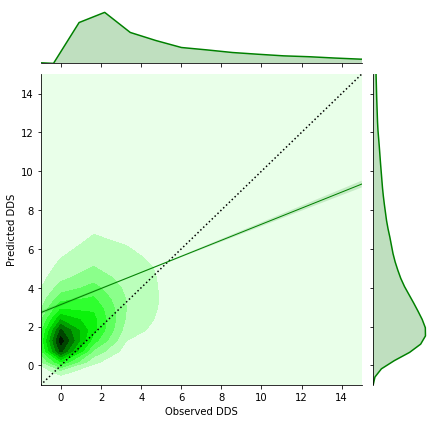

In [75]:
observed = DDS
predicted = base_model.mu
g = sns.jointplot(observed, predicted, kind='kde', color='g', xlim=(-1,15), ylim=(-1,15), stat_func = None)
g.ax_joint.plot([-100,100], [-100,100], color='k', linestyle=':')
sns.regplot(observed, predicted, ax=g.ax_joint, line_kws={'ls':'-' ,'color':'g', 'lw':1}, scatter=False)
g.ax_joint.set_xlabel('Observed DDS')
g.ax_joint.set_ylabel('Predicted DDS')
plt.savefig('DDS_base_model.png');

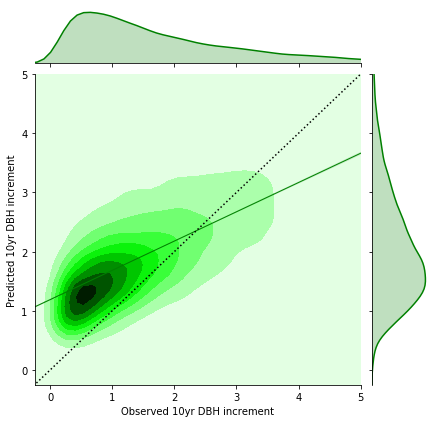

In [76]:
observed = np.sqrt(DDS)
predicted = np.sqrt(base_model.mu)
g = sns.jointplot(observed, predicted, kind='kde', color='g', xlim=(-0.25,5), ylim=(-0.25,5), stat_func = None)
sns.regplot(observed, predicted, ax=g.ax_joint, line_kws={'color':'g', 'lw':1}, scatter=False)
g.ax_joint.plot([-100,100], [-100,100], color='k', linestyle=':')
g.ax_joint.set_xlabel('Observed 10yr DBH increment')
g.ax_joint.set_ylabel('Predicted 10yr DBH increment')
plt.savefig('DBHinch_base_model.png');

In [59]:
def nash_sutcliffe(observed, predicted):
    return 1 - ((predicted - observed)**2).sum()/((observed - observed.mean())**2).sum()
def r_squared(observed, predicted):
    r = ((observed - observed.mean())*(predicted - predicted.mean())).sum()/ \
    ((np.sqrt(((observed - observed.mean())**2).sum()))*(np.sqrt(((predicted - predicted.mean())**2).sum())))
    return r**2
def RMSE(observed, predicted):
    return np.sqrt(((predicted - observed)**2).sum()/len(predicted))

In [67]:
print(nash_sutcliffe(DDS, base_model.mu), nash_sutcliffe(DDS, gamma_model.mu))
print(r_squared(DDS, base_model.mu), r_squared(DDS, gamma_model.mu))
print(r_squared(DDS, gamma2_model.mu))

0.4218377966194691 0.3659607341565423
0.422189651693 0.386890640217
0.00133240923484


In [60]:
print(base_model.aic, gamma_model.aic)
print(base_model.bic, gamma_model.bic)
print(RMSE(DDS, base_model.mu), RMSE(DDS, gamma_model.mu))

235540.421079 186469.384228
990489.202335 -335371.243018
6.13995273941 6.42981173707
